**Import Libraries**

In [1]:
# Standard Libraries
import os
import random

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

# Define parameters
SEED = 42
LEARNING_RATE = 0.005
EPOCHS =  1
BATCH_SIZE = 16

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].apply(lambda x: 1 if 'No finding' in x else 0)

    # Map image filenames to their full paths
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(image_path, 'train', f"{x}.dicom"))
    
    return labels_df

# Path to the labels CSV file
train_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')
# test_csv_path = os.path.join(EXTRACTED_PATH, 'test.csv')

# Load and preprocess the labels
train_val_df = load_labels(train_csv_path, EXTRACTED_PATH)
# test_df = load_labels(test_csv_path, EXTRACTED_PATH)

train_val_df = train_val_df[train_val_df['class_id'] != 14]

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
# print(f"Test size: {test_df.shape[0]}")

Train size: 36096


**Define Dataset for VinDr-CXR images**

In [6]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for VinDr-CXR images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']

        # Retrieve image using pydicom
        ds = pydicom.dcmread(img_path)
        img_array = ds.pixel_array.astype(np.float32)
        img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-5)
        img_array = np.stack([img_array] * 3, axis=-1)
        image = Image.fromarray((img_array * 255).astype(np.uint8))
        
        # Save original image size
        orig_w, orig_h = image.size

        # Retrieve boxes and labels from dataframe
        boxes = self.df.iloc[idx][['x_min', 'y_min', 'x_max', 'y_max']].values.astype(np.float32)
        labels = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation to the image and adjust bounding boxes accordingly.
        if self.transform:
            # Apply transform to the image (e.g., resize, ToTensor, etc.)
            image_transformed = self.transform(image)
            # Assuming the transform includes a resizing step,
            # obtain the new dimensions from the transformed image.
            # (Here we assume image_transformed is a tensor of shape [C, H, W])
            new_h, new_w = image_transformed.shape[1], image_transformed.shape[2]
            # Compute scaling factors
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
            # Adjust the box coordinates
            boxes = boxes * np.array([scale_x, scale_y, scale_x, scale_y])
            image = image_transformed

        return image, boxes, labels


**Define Data Transformations**

In [7]:
import torchvision.transforms as transforms

# Define transformations for training data with data augmentation
train_transforms = transforms.Compose([
    
    # Convert to grayscale and replicate channels to get 3 channels
    transforms.Grayscale(num_output_channels=3),
    
    # Resize the image to 224x224
    transforms.Resize((224, 224)),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
])

**Create Datasets**

In [8]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
# test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

**Plot one sample from batch**

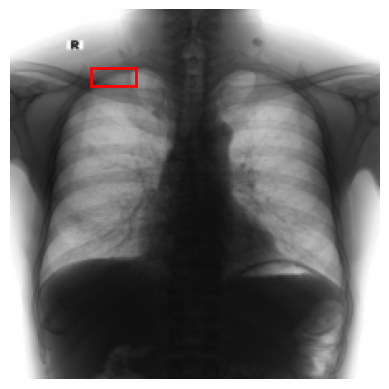

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Retrieve one batch of data from training loader
data_iter = iter(train_loader)
images, boxes, labels = next(data_iter)

num = 4  # index of the sample to display

# Select the image and bounding box for the chosen index
img = images[num]
bbox = boxes[num]

# If your image is a tensor in [C, H, W], convert to [H, W, C] for plotting
if isinstance(img, torch.Tensor):
    img = img.permute(1, 2, 0)

# Extract coordinates
x_min, y_min, x_max, y_max = bbox
width = x_max - x_min
height = y_max - y_min

# Plot the image and overlay the bounding box
fig, ax = plt.subplots(1)
ax.imshow(img.numpy() if isinstance(img, torch.Tensor) else img)
rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                         edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
plt.show()


# **Step 7: Build the Model**

**Initialize the Object Detection Model**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class ObjectDetectionModel(nn.Module):
    """
    Pre-trained DenseNet121 with separate classification and regression heads.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(ObjectDetectionModel, self).__init__()
        # Load pre-trained DenseNet121 model
        base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        
        # We only use the convolutional features from DenseNet121
        self.features = base_model.features  
        # Get the number of features from DenseNet121's classifier input
        in_features = base_model.classifier.in_features
        
        # Define separate heads:
        # Classification head: predicts disease labels (multi-class)
        self.classifier = nn.Linear(in_features, num_classes)
        # Regression head: predicts 4 bounding box coordinates (x_min, y_min, x_max, y_max)
        self.regressor = nn.Linear(in_features, 4)

    def forward(self, x):
        # Extract convolutional features
        features = self.features(x)  # shape: [B, C, H, W]
        # Apply ReLU (DenseNet applies this before pooling)
        out = F.relu(features, inplace=True)
        # Global average pooling to get a feature vector of shape [B, C, 1, 1]
        out = F.adaptive_avg_pool2d(out, (1, 1))
        # Flatten to shape [B, C]
        out = torch.flatten(out, 1)
        
        # Pass the feature vector to the two heads
        class_preds = self.classifier(out)
        bbox_preds = self.regressor(out)
        
        return class_preds, bbox_preds

# Initialize the model and move it to the desired device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ObjectDetectionModel(num_classes=len(disease_labels))
model.to(device)
model = nn.DataParallel(model)

**Use Multiple GPUs**

In [13]:
model = nn.DataParallel(model)

**Define Loss Function and Optimizer**

In [14]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Regression loss for bounding boxes
reg_loss_fn = nn.SmoothL1Loss()

# Classification loss
cls_loss_fn = nn.CrossEntropyLoss()

# **Step 8: Train the Model**

In [15]:
pip install torchmetrics[detection]

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install faster-coco-eval

Note: you may need to restart the kernel to use updated packages.


In [20]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, reg_loss_fn, cls_loss_fn, optimizer, epochs=10):
    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # Lists to store losses and mAP scores
    train_losses = []
    val_losses = []
    val_mAP = []

    for epoch in range(epochs):

        # -----------------
        # Training Phase
        # -----------------
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, boxes, labels in progress_bar:
            break
            # Move data to device
            inputs, boxes, labels = inputs.to(device), boxes.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            class_preds, bbox_preds = model(inputs)

            # Compute losses
            loss_bbox = reg_loss_fn(bbox_preds, boxes)
            loss_class = cls_loss_fn(class_preds, labels)
            loss = loss_bbox + loss_class

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # -----------------
        # Validation Phase
        # -----------------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Val)")
        with torch.no_grad():
            for inputs, boxes, labels in progress_bar_val:
                inputs, boxes, labels = inputs.to(device), boxes.to(device), labels.to(device)

                # Forward pass on validation batch
                class_preds, bbox_preds = model(inputs)

                # Compute validation loss
                loss_bbox = reg_loss_fn(bbox_preds, boxes)
                loss_class = cls_loss_fn(class_preds, labels)
                loss = loss_bbox + loss_class
                val_loss += loss.item() * inputs.size(0)

                # For each image in the batch, prepare prediction and target dictionaries
                batch_size = inputs.size(0)
                for i in range(batch_size):
                    # Process predicted bounding box (ensure it has shape [1, 4])
                    pred_box = bbox_preds[i]
                    if pred_box.dim() == 1:
                        pred_box = pred_box.unsqueeze(0)

                    # Convert class logits to probabilities and determine predicted class and score
                    pred_probs = torch.softmax(class_preds[i], dim=0)
                    pred_score, pred_label = torch.max(pred_probs, dim=0)
                    pred_dict = {
                        "boxes": pred_box.cpu(),  # shape [1,4]
                        "scores": torch.tensor([pred_score.cpu().item()]),
                        "labels": torch.tensor([pred_label.cpu().item()])
                    }

                    # Process ground truth: ensure box is [1,4] and convert one-hot label to index
                    gt_box = boxes[i]
                    if gt_box.dim() == 1:
                        gt_box = gt_box.unsqueeze(0)
                    gt_label = torch.argmax(labels[i]).cpu().item()
                    target_dict = {
                        "boxes": gt_box.cpu(),
                        "labels": torch.tensor([gt_label])
                    }

                    all_preds.append(pred_dict)
                    all_targets.append(target_dict)

        # Average validation loss for the epoch
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Compute mAP using torchmetrics
        metric = MeanAveragePrecision()
        mAP_dict = metric(all_preds, all_targets)
        mAP_default = mAP_dict["map"].item() if isinstance(mAP_dict["map"], torch.Tensor) else mAP_dict["map"]
        val_mAP.append(mAP_default)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, mAP@0.5:0.95: {mAP_default:.4f}")

    return train_losses, val_losses, val_mAP

# Example usage:
# Make sure that 'device' is defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))
train_losses, val_losses, val_mAP = train_model(model, train_loader, val_loader, reg_loss_fn, cls_loss_fn, optimizer, epochs=EPOCHS)


Epoch 1/1:   0%|          | 0/1805 [00:00<?, ?it/s]

Epoch 1/1 (Val): 100%|██████████| 452/452 [05:34<00:00,  1.35it/s]


Epoch 1/1 - Train Loss: 0.0000, Val Loss: 41.2436, mAP@0.5:0.95: 0.0000


# **Step 8: Evaluate the Model**

Ground Truth Label: 0
Predicted Label: 0 with confidence: 0.5381


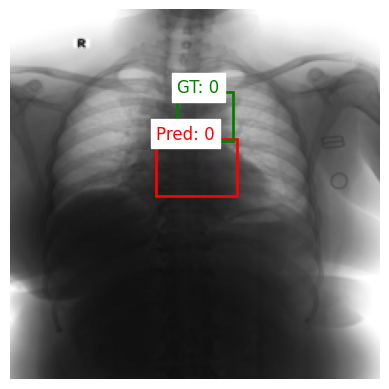

In [23]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def test_single_sample(model, test_loader, device):
    """
    Tests the model on one sample from test_loader, prints the predicted and ground truth
    labels and bounding boxes, and displays the image with both bounding boxes overlaid.
    
    Assumes:
      - The test_loader yields a tuple (images, boxes, labels), where:
          • images: a tensor [B, C, H, W]
          • boxes: a tensor [B, 4] (each box as [x_min, y_min, x_max, y_max])
          • labels: a one-hot tensor [B, num_classes] or a tensor with class indices.
      - The model returns two outputs: class_preds and bbox_preds.
          • class_preds: logits with shape [B, num_classes]
          • bbox_preds: bounding box predictions with shape [B, 4]
    """
    model.eval()
    with torch.no_grad():
        # Retrieve one batch from the test loader
        inputs, boxes, labels = next(iter(test_loader))
        inputs, boxes, labels = inputs.to(device), boxes.to(device), labels.to(device)

        # Select the first sample from the batch
        img = inputs[1]
        gt_box = boxes[1]
        gt_label_tensor = labels[1]

        # Forward pass for one sample
        class_preds, bbox_preds = model(img.unsqueeze(0))  # unsqueeze to add batch dim

        # Process predicted bounding box and class probabilities
        pred_box = bbox_preds[0]
        pred_logits = class_preds[0]
        pred_probs = torch.softmax(pred_logits, dim=0)
        pred_label_idx = torch.argmax(pred_probs)
        pred_score = pred_probs[pred_label_idx]

        # Convert ground truth label to index if it's one-hot encoded
        if gt_label_tensor.dim() > 0 and gt_label_tensor.size(0) > 1:
            gt_label_idx = torch.argmax(gt_label_tensor)
        else:
            gt_label_idx = gt_label_tensor

        # Print out the labels and confidence
        print(f"Ground Truth Label: {gt_label_idx.item()}")
        print(f"Predicted Label: {pred_label_idx.item()} with confidence: {pred_score.item():.4f}")

        # Display the image with both predicted and ground truth bounding boxes
        # Convert image from [C, H, W] to [H, W, C]
        img_disp = img.permute(1, 2, 0).cpu().numpy()

        fig, ax = plt.subplots(1)
        ax.imshow(img_disp)

        # Plot predicted bounding box (red)
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = [p.item() for p in pred_box]
        width_pred = x_max_pred - x_min_pred
        height_pred = y_max_pred - y_min_pred
        rect_pred = patches.Rectangle((x_min_pred, y_min_pred), width_pred, height_pred,
                                      linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect_pred)
        ax.text(x_min_pred, y_min_pred, f"Pred: {pred_label_idx.item()}",
                color='red', fontsize=12, backgroundcolor='white')

        # Plot ground truth bounding box (green)
        x_min_gt, y_min_gt, x_max_gt, y_max_gt = [p.item() for p in gt_box]
        width_gt = x_max_gt - x_min_gt
        height_gt = y_max_gt - y_min_gt
        rect_gt = patches.Rectangle((x_min_gt, y_min_gt), width_gt, height_gt,
                                    linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect_gt)
        ax.text(x_min_gt, y_min_gt, f"GT: {gt_label_idx.item()}",
                color='green', fontsize=12, backgroundcolor='white')

        ax.axis('off')
        plt.show()

# Assume that 'model', 'test_loader', and 'device' are already defined
test_single_sample(model, val_loader, device)